In [1]:
import sys
import os
import math
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt  # To visualize
import numpy as np
from sklearn import mixture
from sklearn.metrics import r2_score

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Get folder location from args
print(str(sys.argv[0]))
#base_directory = '/mnt/DownloadsWindowsShared/Experiment_compare_swarm_and_simulator/Experiment1/attempt2/'
base_directory = '/home/jeanpierre/libra2/libra2/experiments_logs/hpc_logs/attempt10-8machines'
#base_directory = '/home/jeanpierre/Desktop/DownloadsWindowsShared/Experiment_compare_swarm_and_simulator/hpc_logs/attempt10'


#Processing the folders in order
experiment_type = []
experiment_type_part1 = []
experiment_type_part2 = []

for dir_name in os.listdir(base_directory):
    if dir_name.find("_") != -1:
        experiment_type_part1.append(int(dir_name.split('_')[0]))
        experiment_type_part2.append(str(dir_name.split('_')[1]))

experiment_type_part1.sort()
for dir_nr in range(len(experiment_type_part1)):
    experiment_type.append(str(experiment_type_part1[dir_nr]) + "_" + experiment_type_part2[dir_nr])

tmp_frames = [[],[],[],[]]
data_frames = []
for dir_name in experiment_type:
    for experiment_folder in os.listdir(base_directory + "/" + dir_name):
        #tmp_frames[0].append(pd.read_csv(base_directory + "/" + dir_name + "/" + experiment_folder + "/merged/jp_consensus_process_proposal.csv", names=["txns", "duration"]))
        #tmp_frames[1].append(pd.read_csv(base_directory + "/" + dir_name + "/" + experiment_folder + "/merged/jp_mempool_process_incoming_transactions.csv", names=["txns", "duration"]))
        tmp_frames[0].append(pd.read_csv(base_directory + "/" + dir_name + "/" + experiment_folder + "/merged/jp_consensus_process_new_round.csv", names=["txns", "duration", "timeout_round", "timestamp"]))
        tmp_frames[1].append(pd.read_csv(base_directory + "/" + dir_name + "/" + experiment_folder + "/merged/jp_consensus_process_proposal_own.csv", names=["txns", "duration"]))
        tmp_frames[2].append(pd.read_csv(base_directory + "/" + dir_name + "/" + experiment_folder + "/merged/jp_consensus_process_proposal_other.csv", names=["txns", "duration"]))
        tmp_frames[3].append(pd.read_csv(base_directory + "/" + dir_name + "/" + experiment_folder + "/merged/jp_consensus_ensure_round_and_sync_up.csv", names=["txns", "duration"]))
        #tmp_frames[3].append(pd.read_csv(base_directory + "/" + dir_name + "/" + experiment_folder + "/merged/jp_consensus_process_proposal_without_sync.csv", names=["txns", "duration"]))

    #Only take the log data for 1000 transactions
    for i in range(len(tmp_frames)):
        for j in range(len(tmp_frames[i])):
            tmp_frames[i][j] = tmp_frames[i][j][tmp_frames[i][j]['txns'] == max(tmp_frames[i][j]['txns'])]
    
    #merge the files
    for frames in tmp_frames:
        data_frames.append(pd.concat(frames))
    
    tmp_frames = [[],[],[],[]]
        
              
#convert duration from microseconds to milliseconds
i = 0
while i < len(data_frames):
    data_frames[i]["duration"] *= .001
    data_frames[i] = data_frames[i]
    i += 1

print("#entries(0):", len(data_frames[0]))
print("#entries(1):", len(data_frames[1]))
print("#entries(2):", len(data_frames[2]))
print("#entries(3):", len(data_frames[3]))
print("#entries(3):", len(data_frames[4]))
print(len(data_frames))

/home/jeanpierre/anaconda3/lib/python3.8/site-packages/ipykernel_launcher.py
#entries(0): 1666
#entries(1): 1666
#entries(2): 1666
#entries(3): 3332
#entries(3): 1643
60


In [3]:
def get_dist_parameters(index, calculate_round_sync_percentage):
    data = data_frames[index]['duration']
    data = data[data >= 40]
    
    percentage = 1
    if calculate_round_sync_percentage:
        percentage = 1 - ((len(data_frames[index]['duration']) - len(data)) / len(data_frames[index]['duration']))
    
    #Clean the data a bit
    data = data[data.between(data.quantile(0), data.quantile(.98))]
    data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    
    #Gamma dist
    a, loc_gamma, scale_gamma = stats.gamma.fit(data)
    gamma_fit = stats.gamma(a, loc_gamma, scale_gamma)
    p_gamma_fit = stats.kstest(data, gamma_fit.cdf)

    #Beta dist
    alpha, beta, loc_beta, scale_beta = stats.beta.fit(data)
    beta_fit = stats.beta(alpha, beta, loc_beta, scale_beta)
    p_beta_fit = stats.kstest(data, beta_fit.cdf)
    
    if p_gamma_fit[1] >= p_beta_fit[1]:
        sys.stdout.write("gamma:" + str(a) + ":" + str(loc_gamma) + ":" + str(scale_gamma))
    else:
        sys.stdout.write("beta:" + str(alpha) + ":" + str(beta) + ":" + str(loc_beta) + ":" + str(scale_beta))
        
    if calculate_round_sync_percentage:
        sys.stdout.write(":" + str(percentage))
        
    sample_size = int(round(5000*percentage))
    if p_gamma_fit[1] >= p_beta_fit[1]:
        return stats.gamma.rvs(a, loc_gamma, scale_gamma, size=sample_size)
    else:
        return stats.beta.rvs(alpha, beta, loc_beta, scale_beta, size=sample_size)

In [4]:
def get_mixture_multivariate_normal_distribution():
    for index in range(len(experiment_type)):
        data = data_frames[index*4 + 0]['duration']

        #Clean the data a bit
        data = data[data.between(data.quantile(0), data.quantile(.98))]
        data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
        data = data.values.reshape(-1,1)

        model = mixture.GaussianMixture(n_components=2)
        model.fit(data)

        s = '{0},{1}:'
        s_last = '{0},{1}'
        sys.stdout.write(s.format(*model.weights_))
        sys.stdout.write(s.format(*model.means_.flatten()))
        sys.stdout.write(s_last.format(*model.covariances_.flatten()))
        print()
        
        
get_mixture_multivariate_normal_distribution()

0.024946898269360654,0.975053101730639:195.4568946005317,215.77809177830287:348.9467998795841,24.232103680883146
0.9461098848732294,0.05389011512677037:214.26634055307915,182.2846305615573:21.09355104191638,126.88005982729285
0.5246052109683274,0.47539478903167304:213.3115331268384,218.64709576615175:17.704167611791803,132.40736511578828
0.08060934006022588,0.9193906599397741:157.27924968086998,214.8574439786427:1250.7651481986245,42.038202536621604
0.9702127659574468,0.0297872340425532:212.35296491228064,101.54085714285712:116.96185075315485,37.88538197959186
0.882668174355039,0.11733182564496045:211.62406057779918,202.81949466031352:40.19201700450113,1689.9030196532697
0.9486967717273386,0.05130322827266177:219.29436976168176,160.62837933074184:65.32713566705051,6296.41851336123
0.9288593326874033,0.07114066731259669:216.27690389932138,219.52047454673223:75.52253268646767,1558.0418121842426
0.9857142857142858,0.014285714285714296:220.51801449275374,125.63633333333325:87.0933161737029

In [28]:
dist = 'process_proposal'

if dist == 'process_proposal':
    get_mixture_multivariate_normal_distribution()
elif dist == 'process_new_round':
    for x in range(len(experiment_type)):
        index = x*len(tmp_frames) + 1
        get_dist_parameters(index, 0)
        print()
elif dist == 'ensure_round_and_sync_up':
    for x in range(len(experiment_type)):
        index = x*len(tmp_frames) + 2
        get_dist_parameters(index, 1)
        print()
elif dist == 'process_proposal_without_sync':
    for x in range(len(experiment_type)):
        index = x*len(tmp_frames) + 3
        get_dist_parameters(index, 0)
        print()
            
#samples_for_val_0 = []
#samples_for_val_1 = []

#for x in range(len(experiment_type)):
#    for i in range(len(tmp_frames)):
#        index = (x*len(tmp_frames)) + i
#        if i == 2:
#            samples = get_dist_parameters(index, 1)
#            samples_for_val_0 = samples_for_val_0 + [samples]
#        elif i == 3:
#            samples = get_dist_parameters(index, 0)
#            samples_for_val_1 = samples_for_val_1 + [samples]
#        else:
#            get_dist_parameters(index, 0)
#        if i < len(tmp_frames) - 1:
#            sys.stdout.write(',')
#    print()
#    print()
    

0.5210417715681244,0.4789582284318757:53.59713924251903,33.30937320897561:20.497917650433862,2.4658250745080275
0.5300274700614236,0.4699725299385759:58.19542246994169,36.31097801017088:35.3472212939227,4.232158467323348


In [29]:
# MIXTURE MODEL FROM 2 DISTRIBUTIONS
def plot_validate_dist(samples_for_val_0, samples_for_val_1):
    for index in range(len(experiment_type)):
        
        data_dist = np.add(samples_for_val_0[index], samples_for_val_1[index][:len(samples_for_val_0[index])])
        data_dist = np.append(data_dist, samples_for_val_1[index][len(samples_for_val_0[index]):])

        fig, (ax0, ax1) = plt.subplots(2,1,figsize=(16,8))

        data_real = data_frames[index*4 + 0]['duration']
        data_real = data_real[data_real.between(data_real.quantile(0), data_real.quantile(.98))]
        data_real = data_real[(data_real <= data_real.mean() + 3*data_real.std()) & (data_real >= data_real.mean() - 3*data_real.std())]

        x_axis_range = int(max(data_real) - min(data_real))
        sns.histplot(data_real, ax=ax0, stat="density", label="Real Data", binwidth=x_axis_range/150)
        sns.histplot(data_dist, ax=ax1, stat="density", label="Real Data", binwidth=x_axis_range/150)
        ax1.set_xlim(ax0.get_xlim())
        plt.show()

        p_value = stats.ks_2samp(data_real, data_dist)
        print(p_value)
        print("#Samples real: " + str(len(data_real)))
        print("#Samples dist: " + str(len(data_dist)))
    
plot_validate_dist(samples_for_val_0, samples_for_val_1)

NameError: name 'samples_for_val_0' is not defined

Data mean:392.00552042801576
#nodes = 2
P-value(Gaussian Mixture models) = 0.7740603868868566
P-value(Loggamma) = 9.66372332450141e-16
Percentage of data cleaned: 11.83533447684391, #samples: 1028
Means = [[398.59473743]
 [388.42722838]]
weights = [0.35193399 0.64806601]
variances = [[[30.08612527]]

 [[14.60746397]]]
Data mean:421.6029294060365
#nodes = 3
P-value(Gaussian Mixture models) = 0.005521086351477523
P-value(Loggamma) = 1.396631321341172e-15
Percentage of data cleaned: 10.695652173913043, #samples: 2054
Means = [[429.83278499]
 [416.49157809]]
weights = [0.38312511 0.61687489]
variances = [[[63.88649644]]

 [[61.97797121]]]
Data mean:448.468044642857
#nodes = 4
P-value(Gaussian Mixture models) = 0.11325340805760573
P-value(Loggamma) = 6.909724088100442e-06
Percentage of data cleaned: 12.141882673942701, #samples: 2576
Means = [[438.76063514]
 [453.80365047]]
weights = [0.35468991 0.64531009]
variances = [[[105.77087186]]

 [[ 69.00239952]]]
Data mean:481.2269420713862
#nodes

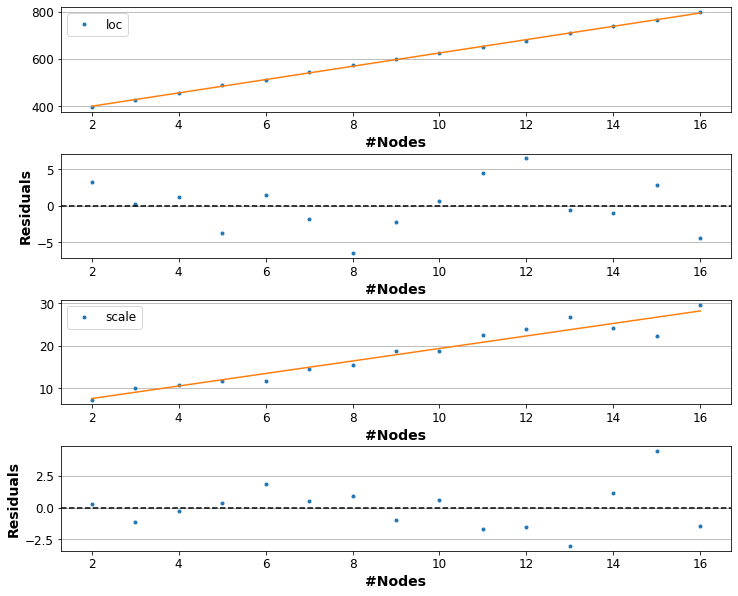

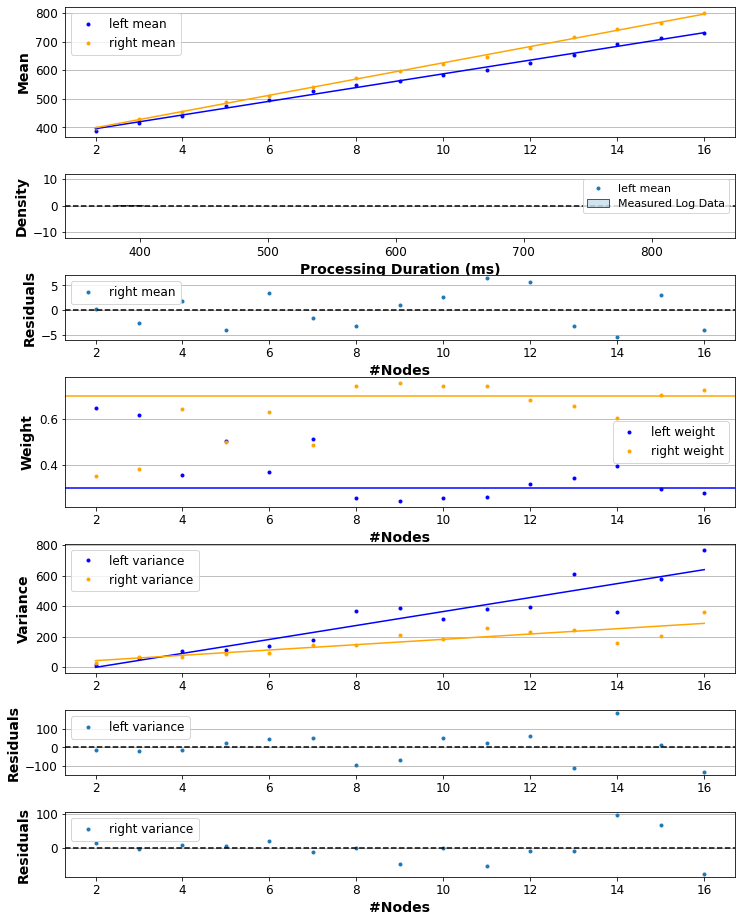

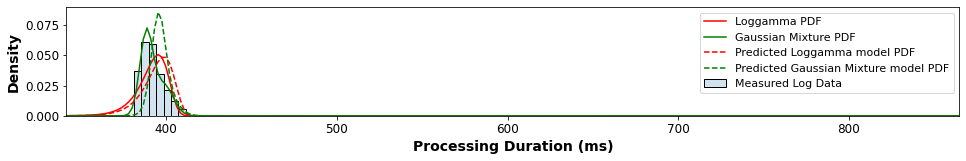

#nodes = 3


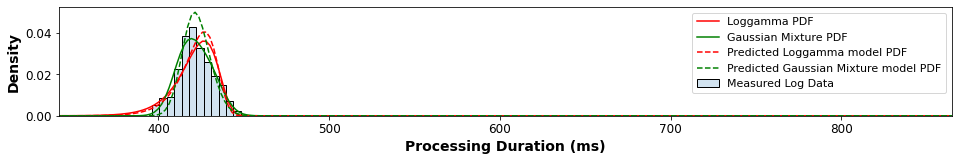

#nodes = 4


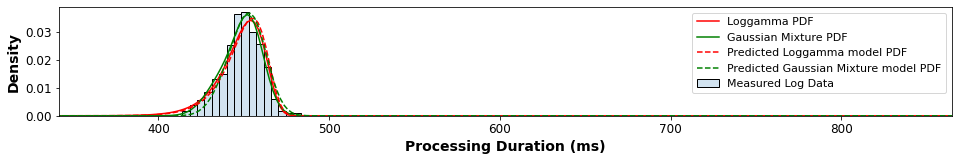

#nodes = 5


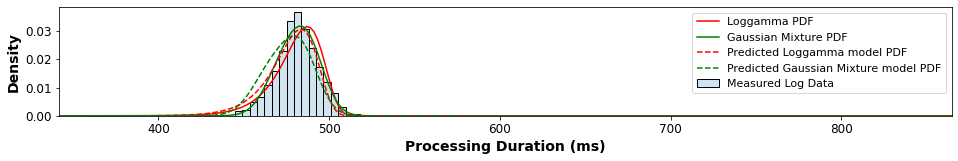

#nodes = 6


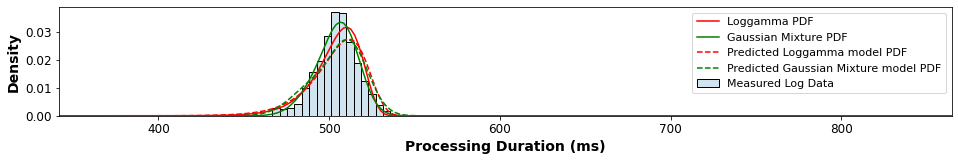

#nodes = 7


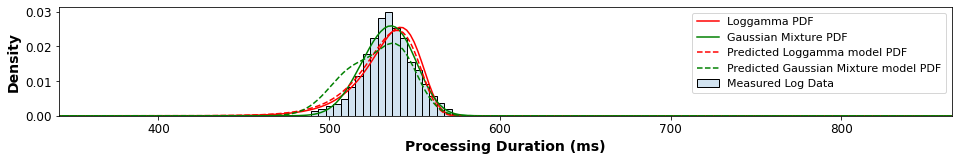

#nodes = 8


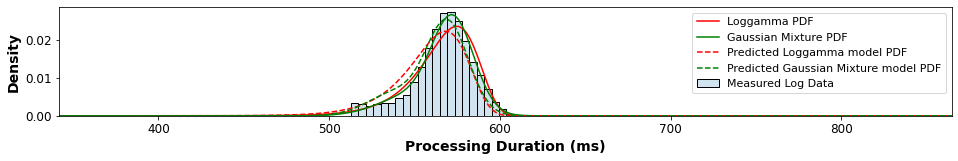

#nodes = 9


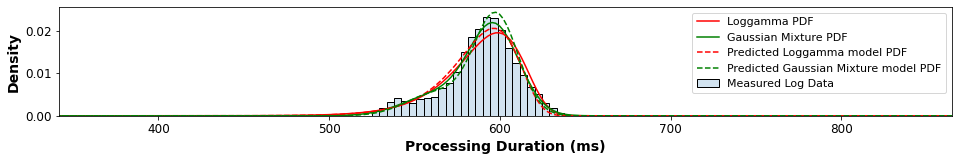

#nodes = 10


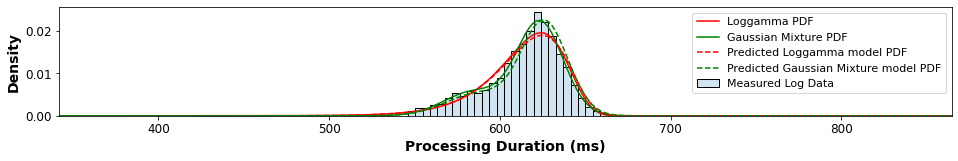

#nodes = 11


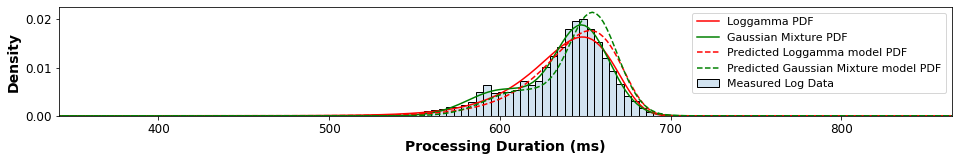

#nodes = 12


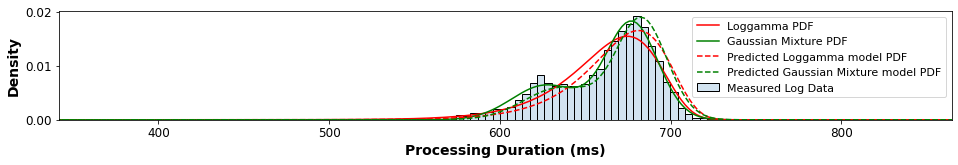

#nodes = 13


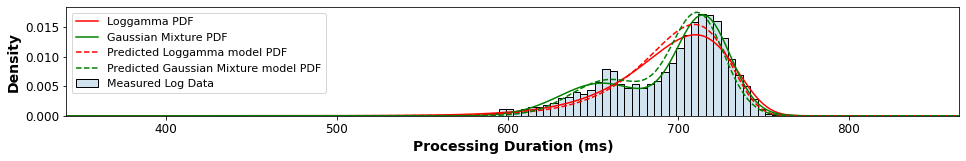

#nodes = 14


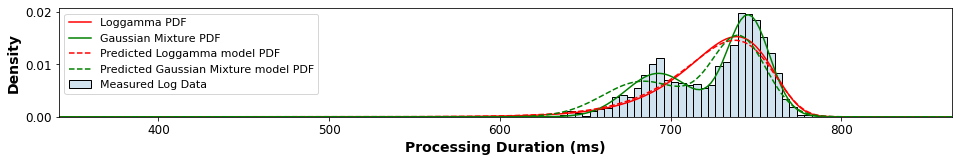

#nodes = 15


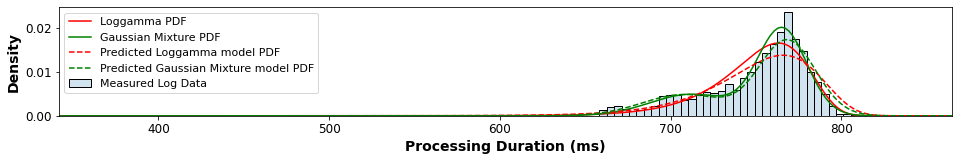

#nodes = 16


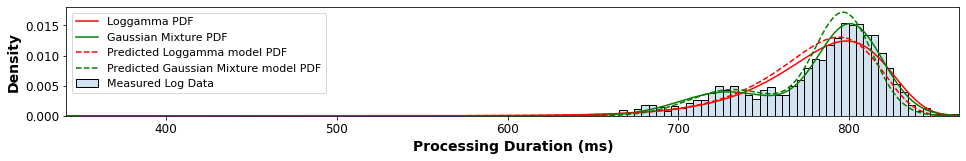

In [13]:
#/merged/jp_consensus_process_new_round.csv
#/merged/jp_consensus_process_proposal_own.csv
#/merged/jp_consensus_process_proposal_other.csv
#/merged/jp_consensus_ensure_round_and_sync_up.csv
frame_number = 2

# Calculate the x-axis limits
data = data_frames[frame_number]['duration']
#data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
xlim_start = np.mean(data) - 1*np.std(data)
data = data_frames[(len(experiment_type)-1) * 4 + frame_number]['duration']
data = data[(data <= data.mean() + 2*data.std()) & (data >= data.mean() - 3*data.std())]
xlim_end = np.mean(data) + 2*np.std(data)
x_axis_range = xlim_end - xlim_start

a_list = []; loc_list = [] ;scale_list = []
means_1 = []; weights_1 = []; variances_1 = []
means_2 = []; weights_2 = []; variances_2 = []
loggamma_models = []; gaussian_mixtures_models = []
cleaned_data = []
p_cleaned = []; nr_samples = []; p_values_loggamma = []; p_values_gaussian = []
for index in range(len(experiment_type)):
    #fig, (ax0, ax1) = plt.subplots(2,1,figsize=(16,4))
    #fig, ax0 = plt.subplots(1,1,figsize=(16,2))

    data = data_frames[index*4 + frame_number]['duration']
    
    #fig2, (ax2) = plt.subplots(1,1,figsize=(16,4))
    #sns.boxplot(data=data.to_numpy(), ax=ax2)
    
    # Let the network warm up and start to measure after warm up
    data = data[round(0.3*len(data)):]

    # Clean the data substantially
    # The data cannot have any outlier behaviour or else the fitting is bad
    data_start = len(data)
    data = data[data.between(data.quantile(0.05), data.quantile(1))]
    data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    data_end = len(data)
    print("Data mean:" + str(data.mean()))
    
    cleaned_data.append(data)
    
    # Plot the data in buckets
    #sns.histplot(data, ax=ax0, stat="density", label="Real Data", binwidth=x_axis_range/150)
    #sns.histplot(data, ax=ax1, stat="density", label="Real Data", binwidth=x_axis_range/150)
    
    # Loggamma modeling BEGIN
    a, loc, scale = stats.loggamma.fit(data, f0=1) #15
    #print("a=" + str(a) + ", loc=" + str(loc) + ", scale=" + str(scale))
    a_list.append(a); loc_list.append(loc); scale_list.append(scale)
    gamma_fit = stats.loggamma(a, loc, scale)
    loggamma_models.append(gamma_fit)
    p_gamma_fit = stats.kstest(data, gamma_fit.cdf)[1]

    # Plotting the Loggamma distribution
    X = np.linspace(xlim_start, xlim_end, 300)
    #ax0.plot(X, gamma_fit.pdf(X), label="Loggamma PDF")
    # Loggamma modeling END
    
    # Gaussian Mixture modeling BEGIN
    data_gaussian = data.values.reshape(-1,1)
    model = mixture.GaussianMixture(n_components=2)
    model.fit(data_gaussian)
    gaussian_mixtures_models.append(model)
    data_samples = model.sample(len(data_gaussian))
    
    #sns.histplot(data_samples[0], ax=ax1, stat="density", label="Real Data", binwidth=x_axis_range/150)
    # Gaussian Mixture modeling END

    print('#nodes = ' + str(index+2))
    p_value = stats.ks_2samp(np.array(data_gaussian).flatten(), data_samples[0].flatten())
    print('P-value(Gaussian Mixture models) = ' + str(p_value[1]))
    p_values_gaussian.append(p_value[1])
    print('P-value(Loggamma) = ' + str(p_gamma_fit))
    p_values_loggamma.append(p_gamma_fit)
    p_data_cleaned = (data_start-data_end)/data_start*100
    p_cleaned.append(p_data_cleaned)
    nr_samples.append(data_end)
    print("Percentage of data cleaned: " + str(p_data_cleaned) + ", #samples: " + str(data_end))
    print('Means = ' + str(model.means_))
    print('weights = ' + str(model.weights_))
    print('variances = ' + str(model.covariances_))
    
    # For plotting the means, weights and variances of the gaussian mixture models
    if model.means_[0][0] < model.means_[1][0]:
        means_1.append(model.means_[0][0])
        weights_1.append(model.weights_[0])
        variances_1.append(model.covariances_[0][0][0])
        means_2.append(model.means_[1][0])
        weights_2.append(model.weights_[1])
        variances_2.append(model.covariances_[1][0][0])
    else:
        means_1.append(model.means_[1][0])
        weights_1.append(model.weights_[1])
        variances_1.append(model.covariances_[1][0][0])
        means_2.append(model.means_[0][0])
        weights_2.append(model.weights_[0])
        variances_2.append(model.covariances_[0][0][0])
        
    # Plot the PDF
    norm_params = np.array([[means_1[-1], math.sqrt(variances_1[-1])],
                            [means_2[-1], math.sqrt(variances_2[-1])]])
    
    xs = np.linspace(300, 900, 300)
    ys = np.zeros_like(xs)
    for (l, s), w in zip(norm_params, [weights_1[-1], weights_2[-1]]):
        ys += stats.norm.pdf(xs, loc=l, scale=s) * w
    #ax0.plot(xs, ys, label='Gaussian Mixture PDF')
    #ax0.set_xlim(xlim_start, xlim_end)
    #ax1.set_xlim(xlim_start, xlim_end)
    #ax0.legend()
    #plt.show()
    
# Plot the loc and scale parameters and perform linear fit
print()
print("Loggamma loc and scale model parameters:")
coefficients_loc = np.polyfit(range(2, len(loc_list)+2), loc_list, 1)
print(coefficients_loc)
poly_loc = np.poly1d(coefficients_loc)

coefficients_scale = np.polyfit(range(2, len(scale_list)+2), scale_list, 1)
print(coefficients_scale)
poly_scale = np.poly1d(coefficients_scale)

fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,1,figsize=(12,10), gridspec_kw={'hspace':0.4})
# Plot loc + residuals
ax0.plot(range(2, len(loc_list)+2), loc_list, '.', label="loc")
ax0.plot(range(2, len(loc_list)+2), poly_loc(range(2, len(loc_list)+2)))
ax0.grid(axis='y')
#ax0.set_title("Growth of the loc parameter", fontweight='bold')
ax0.set_xlabel('#Nodes', fontweight='bold')
ax0.xaxis.label.set_size(14)
ax0.yaxis.label.set_size(14)
ax0.xaxis.set_tick_params(labelsize=12)
ax0.yaxis.set_tick_params(labelsize=12)
ax0.legend(fontsize=12)

pred_loc = poly_loc(range(2, len(loc_list)+2)) - loc_list
ax1.plot(range(2, len(loc_list)+2), pred_loc, '.')
ax1.set_xlabel('#Nodes', fontweight='bold')
ax1.set_ylabel('Residuals', fontweight='bold')
ax1.grid(axis='y')
ax1.axhline(y=0, c='black', ls='--')
ax1.xaxis.label.set_size(14)
ax1.yaxis.label.set_size(14)
ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=12)
print("R2 score (loc): " + str(r2_score(loc_list, poly_loc(range(2, len(loc_list)+2)))))

# Plot scale + residuals
ax2.plot(range(2, len(scale_list)+2), scale_list, '.', label="scale")
ax2.plot(range(2, len(scale_list)+2), poly_scale(range(2, len(scale_list)+2)))
ax2.grid(axis='y')
#ax2.set_title("Growth of the scale parameter", fontweight='bold')
ax2.set_xlabel('#Nodes', fontweight='bold')
ax2.xaxis.label.set_size(14)
ax2.yaxis.label.set_size(14)
ax2.xaxis.set_tick_params(labelsize=12)
ax2.yaxis.set_tick_params(labelsize=12)
ax2.legend(fontsize=12);

pred_scale = poly_scale(range(2, len(scale_list)+2)) - scale_list
ax3.plot(range(2, len(scale_list)+2), pred_scale, '.')
ax3.set_xlabel('#Nodes', fontweight='bold')
ax3.set_ylabel('Residuals', fontweight='bold')
ax3.grid(axis='y')
ax3.axhline(y=0, c='black', ls='--')
ax3.xaxis.label.set_size(14)
ax3.yaxis.label.set_size(14)
ax3.xaxis.set_tick_params(labelsize=12)
ax3.yaxis.set_tick_params(labelsize=12)
print("R2 score (scale): " + str(r2_score(scale_list, poly_scale(range(2, len(scale_list)+2)))))

# Plot the gaussian mixture models
# Means
fig, (ax0, ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(7,1,figsize=(12,16), gridspec_kw={'hspace':0.4, 'height_ratios':[2,1,1,2,2,1,1]})
ax0.plot(range(2, len(means_1)+2), means_1, '.', color="blue", label="left mean")
ax0.plot(range(2, len(means_2)+2), means_2, '.', color="orange", label="right mean")
ax0.set_xlabel('', fontweight='bold')
ax0.set_ylabel('Mean', fontweight='bold')
ax0.grid(axis='y')
ax0.xaxis.label.set_size(14)
ax0.yaxis.label.set_size(14)
ax0.xaxis.set_tick_params(labelsize=12)
ax0.yaxis.set_tick_params(labelsize=12)
ax0.legend(fontsize=12)

# Weights
ax3.plot(range(2, len(weights_1)+2), weights_1, '.', color="blue", label="left weight")
ax3.plot(range(2, len(weights_2)+2), weights_2, '.', color="orange", label="right weight")
ax3.set_xlabel('#Nodes', fontweight='bold')
ax3.set_ylabel('Weight', fontweight='bold')
ax3.grid(axis='y')
ax3.xaxis.label.set_size(14)
ax3.yaxis.label.set_size(14)
ax3.xaxis.set_tick_params(labelsize=12)
ax3.yaxis.set_tick_params(labelsize=12)
ax3.legend(fontsize=12)
# Variances
ax4.plot(range(2, len(variances_1)+2), variances_1, '.', color="blue", label="left variance")
ax4.plot(range(2, len(variances_2)+2), variances_2, '.', color="orange", label="right variance")
ax4.set_xlabel('', fontweight='bold')
ax4.set_ylabel('Variance', fontweight='bold')
ax4.grid(axis='y')
ax4.xaxis.label.set_size(14)
ax4.yaxis.label.set_size(14)
ax4.xaxis.set_tick_params(labelsize=12)
ax4.yaxis.set_tick_params(labelsize=12)
ax4.legend(fontsize=12)

# Fit Means, Weights and variances into a linear model
# Means
coefficients_mean_1 = np.polyfit(range(2, len(means_1)+2), means_1, 1)
coefficients_mean_2 = np.polyfit(range(2, len(means_2)+2), means_2, 1)
poly_mean_1 = np.poly1d(coefficients_mean_1)
poly_mean_2 = np.poly1d(coefficients_mean_2)
ax0.plot(range(2, len(means_1)+2), poly_mean_1(range(2, len(means_1)+2)), color="blue", label="left weight model")
ax0.plot(range(2, len(means_2)+2), poly_mean_2(range(2, len(means_1)+2)), color="orange", label="right weight model")
print("Gaussian mixture model parameters:")
print("Mean1: " + str(coefficients_mean_1) + " R^2 score (left): " + str(r2_score(means_1, poly_mean_1(range(2, len(means_1)+2)))))
print("Mean2: " + str(coefficients_mean_2) + " R^2 score (right): " + str(r2_score(means_2, poly_mean_2(range(2, len(means_2)+2)))))

# Residuals
pred_mean_1 = poly_mean_1(range(2, len(means_1)+2)) - means_1
ax1.plot(range(2, len(means_1)+2), pred_mean_1, '.', label='left mean')
ax1.set_ylabel('Residuals', fontweight='bold')
ax1.grid(axis='y')
ax1.axhline(y=0, c='black', ls='--')
ax1.xaxis.label.set_size(14)
ax1.yaxis.label.set_size(14)
ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=12)
ax1.legend(fontsize=12)

pred_mean_2 = poly_mean_2(range(2, len(means_2)+2)) - means_2
ax2.plot(range(2, len(means_2)+2), pred_mean_2, '.', label='right mean')
ax2.set_xlabel('#Nodes', fontweight='bold')
ax2.set_ylabel('Residuals', fontweight='bold')
ax2.grid(axis='y')
ax2.axhline(y=0, c='black', ls='--')
ax2.xaxis.label.set_size(14)
ax2.yaxis.label.set_size(14)
ax2.xaxis.set_tick_params(labelsize=12)
ax2.yaxis.set_tick_params(labelsize=12)
ax2.legend(fontsize=12)

# Weights
ax3.axhline(y=.3, color="blue")
ax3.axhline(y=.7, color="orange")

#Variances
coefficients_variance_1 = np.polyfit(range(2, len(variances_1)+2), variances_1, 1)
coefficients_variance_2 = np.polyfit(range(2, len(variances_2)+2), variances_2, 1)
poly_variance_1 = np.poly1d(coefficients_variance_1)
poly_variance_2 = np.poly1d(coefficients_variance_2)
ax4.plot(range(2, len(variances_1)+2), poly_variance_1(range(2, len(variances_1)+2)), color="blue", label="left variance model")
ax4.plot(range(2, len(variances_2)+2), poly_variance_2(range(2, len(variances_2)+2)), color="orange", label="right variance model")
print("Variance1: " + str(coefficients_variance_1) + " R^2 score (left): " + str(r2_score(variances_1, poly_variance_1(range(2, len(variances_1)+2)))))
print("Variance2: " + str(coefficients_variance_2) + " R^2 score (right): " + str(r2_score(variances_2, poly_variance_2(range(2, len(variances_2)+2)))))

# Residuals
pred_variance_1 = poly_variance_1(range(2, len(variances_1)+2)) - variances_1
ax5.plot(range(2, len(means_1)+2), pred_variance_1, '.', label='left variance')
ax5.set_ylabel('Residuals', fontweight='bold')
ax5.grid(axis='y')
ax5.axhline(y=0, c='black', ls='--')
ax5.xaxis.label.set_size(14)
ax5.yaxis.label.set_size(14)
ax5.xaxis.set_tick_params(labelsize=12)
ax5.yaxis.set_tick_params(labelsize=12)
ax5.legend(fontsize=12)

pred_variance_2 = poly_variance_2(range(2, len(variances_2)+2)) - variances_2
ax6.plot(range(2, len(variances_2)+2), pred_variance_2, '.', label='right variance')
ax6.set_xlabel('#Nodes', fontweight='bold')
ax6.set_ylabel('Residuals', fontweight='bold')
ax6.grid(axis='y')
ax6.axhline(y=0, c='black', ls='--')
ax6.xaxis.label.set_size(14)
ax6.yaxis.label.set_size(14)
ax6.xaxis.set_tick_params(labelsize=12)
ax6.yaxis.set_tick_params(labelsize=12)
ax6.legend(fontsize=12)

#Calculate the P-values for the Gaussian mixture model
gaussian_model_samples = []
for i in range(2, 17):
    l_var = poly_variance_1(i)
    if (l_var < 30):
        l_var = 30
    samples_1 = np.random.normal(poly_mean_1(i), math.sqrt(l_var), int(.3*nr_samples[i-2]))
    samples_2 = np.random.normal(poly_mean_2(i), math.sqrt(poly_variance_2(i)), int(.7*nr_samples[i-2]))
    samples = np.concatenate((samples_1, samples_2))
    gaussian_model_samples.append(samples)

# Plot the models
p_values_gaussian_model = []
for index in range(len(experiment_type)):
    fig, (ax0) = plt.subplots(1,1,figsize=(16,2))
    # Plot the data in buckets
    sns.histplot(cleaned_data[index], ax=ax0, stat="density", label="Measured Log Data", binwidth=x_axis_range/150, alpha=0.2)
    sns.histplot(cleaned_data[index], ax=ax1, stat="density", label="Measured Log Data", binwidth=x_axis_range/150, alpha=0.2)
    # Plotting the Loggamma PDF
    X = np.linspace(xlim_start, xlim_end, 300)
    ax0.plot(X, loggamma_models[index].pdf(X), 'r-', label="Loggamma PDF")
    # Plotting the Gaussian Mixtures PDF
    norm_params = np.array([[means_1[index], math.sqrt(variances_1[index])],
                            [means_2[index], math.sqrt(variances_2[index])]])
    xs = np.linspace(xlim_start, xlim_end, 300)
    ys = np.zeros_like(xs)
    for (l, s), w in zip(norm_params, [weights_1[index], weights_2[index]]):
        ys += stats.norm.pdf(xs, loc=l, scale=s) * w
    ax0.plot(xs, ys, 'g-', label='Gaussian Mixture PDF')
    
    # Plotting the loggamma model PDF
    loc = poly_loc(index + 2)
    scale = poly_scale(index + 2)
    loggamma_predicted_fit = stats.loggamma(1, loc, scale)
    ax0.plot(X, loggamma_predicted_fit.pdf(X), 'r--', label='Predicted Loggamma model PDF')
    
    # Plotting the Predicted Gaussian Mixtures model PDF
    mean1 = poly_mean_1(index + 2)
    mean2 = poly_mean_2(index + 2)
    std1 = poly_variance_1(index + 2)
    std2 = poly_variance_2(index + 2)
    if std1 < 15:
        std1 = 15
    if std2 < 15:
        std2 = 15
    
    norm_params = np.array([[mean1, math.sqrt(std1)],
                            [mean2, math.sqrt(std2)]])
    xs = np.linspace(xlim_start, xlim_end, 300)
    ys = np.zeros_like(xs)
    for (l, s), w in zip(norm_params, [weights_1[index], weights_2[index]]):
        ys += stats.norm.pdf(xs, loc=l, scale=s) * w
    ax0.plot(xs, ys, 'g--', label='Predicted Gaussian Mixture model PDF')
    # Print statistics
    print('#nodes = ' + str(index+2))
    p_loggamma_fit = stats.kstest(cleaned_data[index], loggamma_models[index].cdf)[1]
    p_loggamma_predicted_fit = stats.kstest(cleaned_data[index], loggamma_predicted_fit.cdf)[1]
    #print('P-value(Loggamma) = ' + str(p_loggamma_fit))
    #print('P-value(Predicted Loggamma) = ' + str(p_loggamma_predicted_fit))
    
    data_samples = gaussian_mixtures_models[index].sample(len(cleaned_data[index]))
    #data_samples_pred = gaussian_mixtures_models[index].sample(len(cleaned_data[index]))
    p_value = stats.ks_2samp(np.array(cleaned_data[index].values.reshape(-1,1)).flatten(), data_samples[0].flatten())
    p_value_gaussian_model = stats.ks_2samp(np.array(cleaned_data[index].values.reshape(-1,1)).flatten(), gaussian_model_samples[index])
    p_values_gaussian_model.append(p_value_gaussian_model)
    #print('P-value(Gaussian Mixture) = ' + str(p_value[1]))
    #print('P-value(Predicted Gaussian Mixture) = ' + str(p_value_gaussian_model[1]))
    
    
    #x, y = np.histogram(cleaned_data[index], density=True)
    #print(x)
    #print()
    #print(y)
    #print()
    #print(gaussian_mixtures_models[index].predict(np.reshape([400, 500, 600], (-1, 1))))
    #model.predict()
    
    #print(str(r2_score(model.predict(), poly_mean_1(range(2, len(means_1)+2)))))
        
    # Set the plots limits and legend
    ax0.set_xlim(xlim_start*1.1, xlim_end*0.9)
    ax1.set_xlim(xlim_start*1.1, xlim_end*0.9)
    
    ax0.set_xlabel('Processing Duration (ms)', fontweight='bold')
    ax0.set_ylabel('Density', fontweight='bold')
    ax1.set_xlabel('Processing Duration (ms)', fontweight='bold')
    ax1.set_ylabel('Density', fontweight='bold')
    
    ax0.xaxis.label.set_size(14)
    ax0.yaxis.label.set_size(14)
    ax0.xaxis.set_tick_params(labelsize=12)
    ax0.yaxis.set_tick_params(labelsize=12)
    ax1.xaxis.label.set_size(14)
    ax1.yaxis.label.set_size(14)
    ax1.xaxis.set_tick_params(labelsize=12)
    ax1.yaxis.set_tick_params(labelsize=12)
    
    ax0.legend(fontsize=11)
    ax1.legend(fontsize=11)
    plt.show()

In [35]:
print('%data removed')
for x in p_cleaned:
    print(round(x,2))
print('#samples')
for x in nr_samples:
    print(round(x,2))
print('a')
for x in a_list:
    print(round(x,2))
print('loc')
for x in poly_loc(range(2, len(loc_list)+2)):
    print(round(x,2))
print('scale')
for x in poly_scale(range(2, len(scale_list)+2)):
    print(round(x,2))
print('P-value-real')
for x in p_values_gamma:
    print(round(x,2))
print('P-value-model')
for x in p_loggamma_predicted_fit:
    print(round(x,2))

%data removed
11.84
10.7
12.14
11.4
13.76
11.71
11.13
9.99
11.18
10.44
11.65
12.26
9.78
11.36
9.01
#samples
1028
2054
2576
3418
3059
4793
5262
6074
5941
6933
7113
4574
1614
1529
1849
a
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
loc
398.69
426.94
455.19
483.44
511.68
539.93
568.18
596.43
624.68
652.93
681.17
709.42
737.67
765.92
794.17
scale
7.56
9.03
10.5
11.97
13.45
14.92
16.39
17.86
19.34
20.81
22.28
23.76
25.23
26.7
28.17
P-value-real
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
P-value-model


TypeError: 'numpy.float64' object is not iterable

In [87]:
print('%data removed')
for x in p_cleaned:
    print(round(x,2))
print('#samples')
for x in nr_samples:
    print(round(x,2))
print('weights_left')
for x in np.full(len(means_1), .3, dtype=float):
    print(x)
print('weights_right')
for x in np.full(len(means_2), .7, dtype=float):
    print(x)
print('mean_left')
for x in poly_mean_1(range(2, len(means_1)+2)):
    print(round(x,2))
print('mean_right')
for x in poly_mean_2(range(2, len(means_2)+2)):
    print(round(x,2))
print('var_left')
for x in poly_variance_1(range(2, len(variances_1)+2)):
    print(round(x,2))
print('var_right')
for x in poly_variance_2(range(2, len(variances_1)+2)):
    print(round(x,2))
print('P-value-gaussian-real')
for x in p_values_gaussian:
    print(round(x,2))
print('P-value-gaussian-model')
for x in p_values_gaussian_model:
    print(round(x[1],2))

%data removed
11.84
10.7
12.14
11.4
13.76
11.71
11.13
9.99
11.18
10.44
11.65
12.26
9.78
11.36
9.01
#samples
1028
2054
2576
3418
3059
4793
5262
6074
5941
6933
7113
4574
1614
1529
1849
weights_left
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
weights_right
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
mean_left
395.3
419.34
443.38
467.41
491.45
515.49
539.53
563.56
587.6
611.64
635.68
659.72
683.75
707.79
731.83
mean_right
398.77
427.2
455.63
484.06
512.49
540.92
569.35
597.78
626.21
654.64
683.07
711.5
739.93
768.36
796.79
var_left
-1.36
44.54
90.43
136.32
182.22
228.11
274.01
319.9
365.8
411.69
457.58
503.48
549.37
595.27
641.16
var_right
43.19
60.61
78.03
95.46
112.88
130.31
147.73
165.16
182.58
200.0
217.43
234.85
252.28
269.7
287.12
P-value-gaussian-real
0.66
0.03
0.02
0.2
0.0
0.01
0.08
0.01
0.29
0.75
0.65
0.03
0.47
0.49
0.48
P-value-gaussian-model
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.02
0.0
0.0


In [18]:
for i in range(4, 101, 4):
    print(i)

4
8
12
16
20
24
28
32
36
40
44
48
52
56
60
64
68
72
76
80
84
88
92
96
100


#nodes = 2
a=1, loc=264.44315182327824, scale=115.80946892826117
(array(197.59611221), array(22061.58115429))


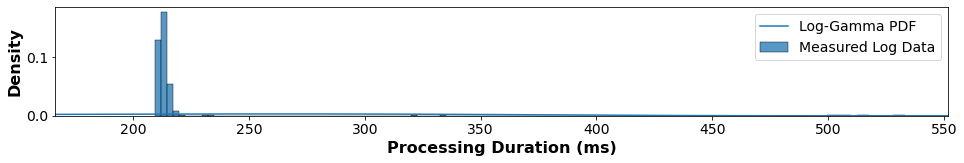

P-value(gamma) = KstestResult(statistic=0.4627179714073879, pvalue=4.4899988374477474e-229)
Percentage of data cleaned: 0.0, #samples: 1166
#nodes = 3
a=1, loc=281.85404202496693, scale=163.39466814531679
(array(187.54008001), array(43916.14964508))


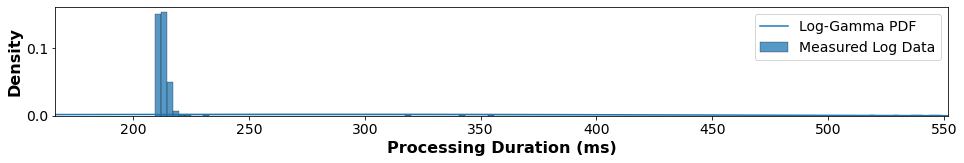

P-value(gamma) = KstestResult(statistic=0.4737984886319259, pvalue=1.5398788283990337e-237)
Percentage of data cleaned: 0.0, #samples: 1150
#nodes = 4
a=1, loc=316.0960242777325, scale=213.48549033421705
(array(192.86885503), array(74969.60481651))


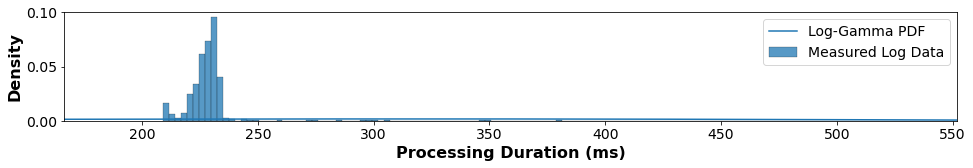

P-value(gamma) = KstestResult(statistic=0.45453422185273096, pvalue=6.179511423712546e-185)
Percentage of data cleaned: 0.0, #samples: 977
#nodes = 5
a=1, loc=350.59041552160966, scale=248.37765183869914
(array(207.22294407), array(101478.38078737))


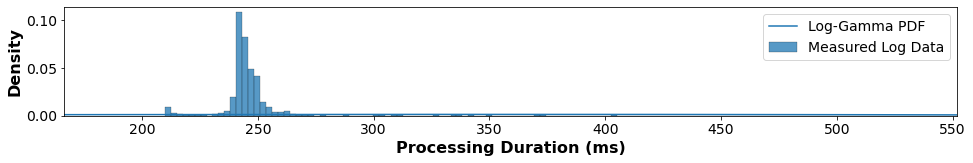

P-value(gamma) = KstestResult(statistic=0.43392324389684145, pvalue=1.0388690559995996e-165)
Percentage of data cleaned: 0.0, #samples: 965
#nodes = 6
a=1, loc=399.7964877941509, scale=369.6620656719122
(array(186.42175277), array(224780.31063277))


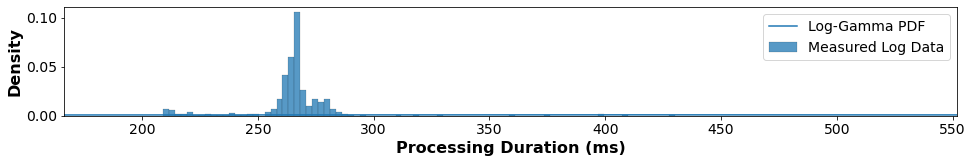

P-value(gamma) = KstestResult(statistic=0.44962597243348756, pvalue=2.009151146584885e-132)
Percentage of data cleaned: 0.0, #samples: 715
#nodes = 7
a=1, loc=442.870371114745, scale=395.97877738089164
(array(214.30521784), array(257924.3327989))


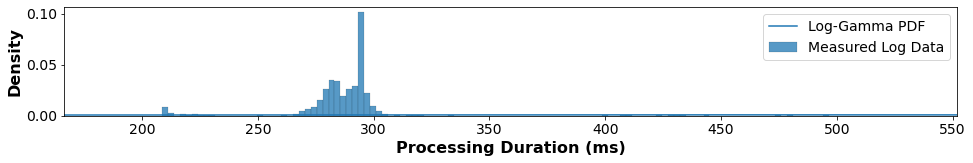

P-value(gamma) = KstestResult(statistic=0.4338690218165775, pvalue=2.129278186265401e-155)
Percentage of data cleaned: 0.0, #samples: 905
#nodes = 8
a=1, loc=487.7053396872614, scale=463.9427906543675
(array(219.9102933), array(354060.40024162))


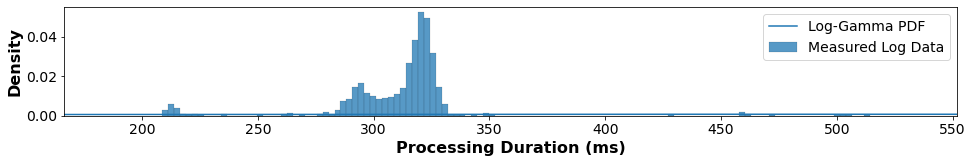

P-value(gamma) = KstestResult(statistic=0.43489939271742584, pvalue=5.037215579250643e-146)
Percentage of data cleaned: 0.0, #samples: 846
#nodes = 9
a=1, loc=507.7651136392193, scale=471.61644036347707
(array(235.54071644), array(365869.63493285))


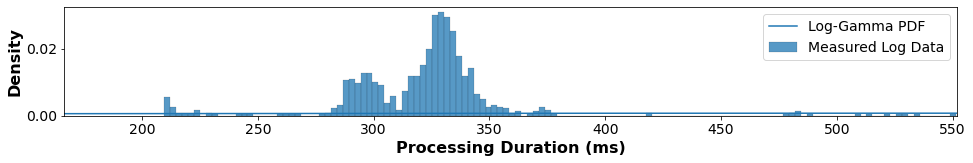

P-value(gamma) = KstestResult(statistic=0.4199798381757224, pvalue=1.9596671995381018e-135)
Percentage of data cleaned: 0.0, #samples: 844
#nodes = 10
a=1, loc=579.999104066984, scale=664.3620686927516
(array(196.51891085), array(726035.99505865))


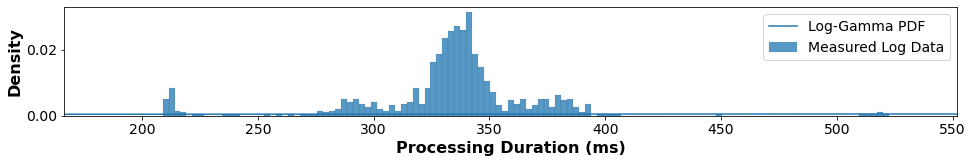

P-value(gamma) = KstestResult(statistic=0.43559737194907394, pvalue=4.375638662319259e-129)
Percentage of data cleaned: 0.0, #samples: 745
#nodes = 11
a=1, loc=520.2748087077744, scale=435.6418995274489
(array(268.81548001), array(312181.94425794))


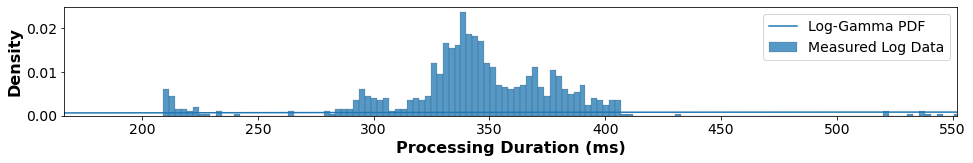

P-value(gamma) = KstestResult(statistic=0.4105671322124036, pvalue=1.1377229531954212e-118)
Percentage of data cleaned: 0.0, #samples: 775
#nodes = 12
a=1, loc=577.1525419436318, scale=546.0420995740869
(array(261.96848837), array(490456.78930575))


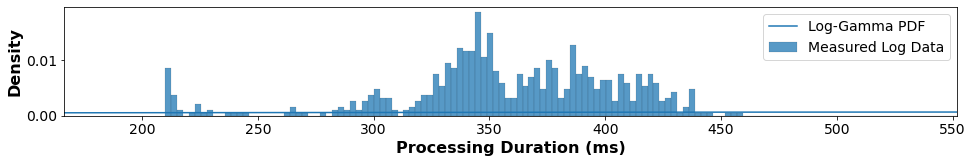

P-value(gamma) = KstestResult(statistic=0.4040119767982798, pvalue=1.0060511285381753e-108)
Percentage of data cleaned: 0.0, #samples: 734
#nodes = 13
a=1, loc=627.6906194353433, scale=724.9670092063157
(array(209.22830518), array(864539.78254082))


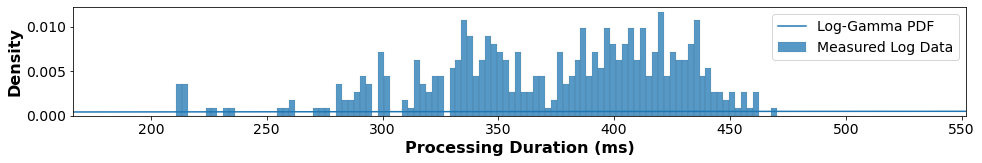

P-value(gamma) = KstestResult(statistic=0.4302735018063688, pvalue=1.1295930935231827e-73)
Percentage of data cleaned: 0.0, #samples: 435
#nodes = 14
a=1, loc=583.6992874191108, scale=514.6228596580058
(array(286.65091131), array(435638.88972033))


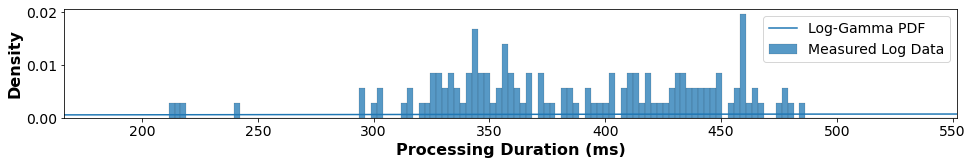

P-value(gamma) = KstestResult(statistic=0.40551404951013437, pvalue=3.642438794382812e-21)
Percentage of data cleaned: 0.0, #samples: 139
#nodes = 15
a=1, loc=610.8590801847702, scale=506.116652156155
(array(318.72062029), array(421356.54885026))


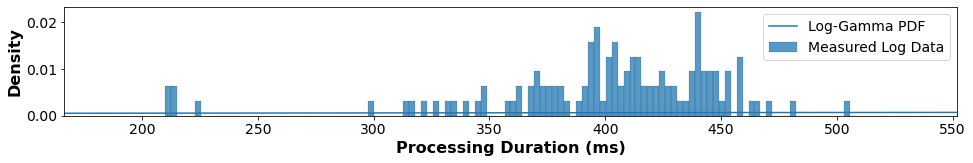

P-value(gamma) = KstestResult(statistic=0.4118825740067309, pvalue=2.1558993620777218e-19)
Percentage of data cleaned: 0.0, #samples: 123
#nodes = 16
a=1, loc=584.6411856357092, scale=468.1984136430098
(array(314.389727), array(360585.59302472))


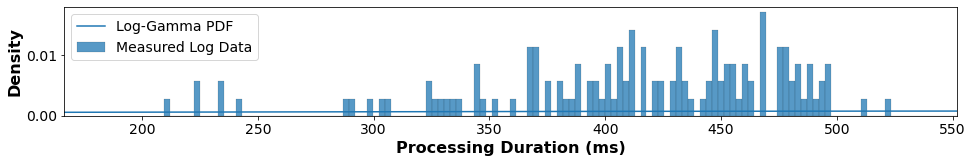

P-value(gamma) = KstestResult(statistic=0.384738683538678, pvalue=1.2706576835226254e-18)
Percentage of data cleaned: 0.0, #samples: 136

Loc and Scale coefficients:
[ 26.57501571 236.52069682]
[ 31.22851578 139.0912484 ]
R2 score (loc): 0.9012900579239014
R2 score (scale): 0.6413991814417215


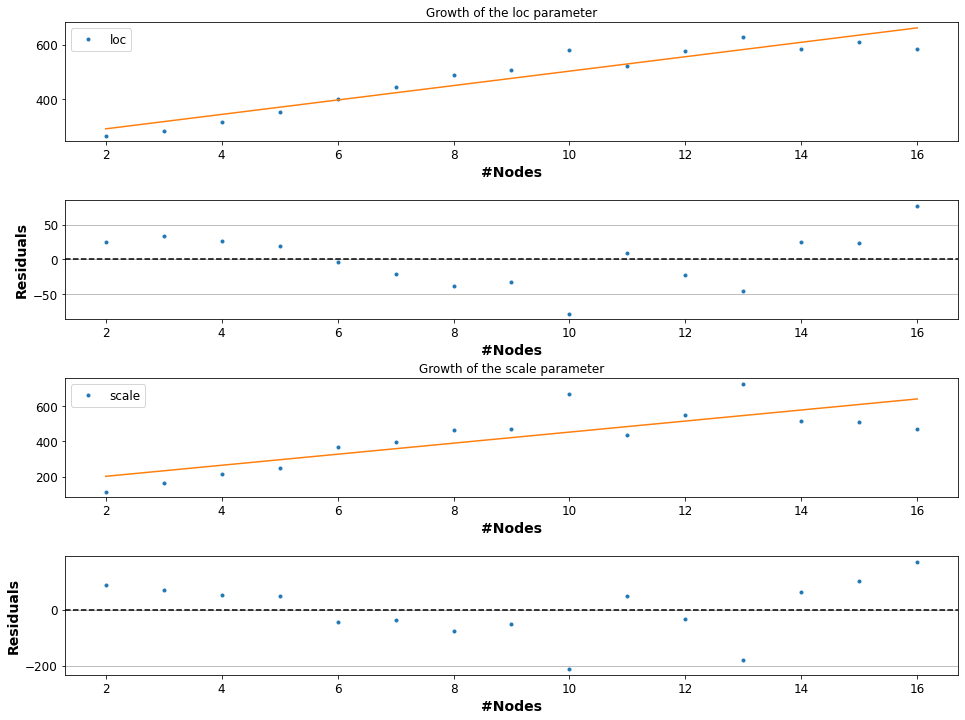

In [11]:
#/merged/jp_consensus_process_new_round.csv
#/merged/jp_consensus_process_proposal_own.csv
#/merged/jp_consensus_process_proposal_other.csv
#/merged/jp_consensus_ensure_round_and_sync_up.csv
frame_number = 1

# Calculate the x-axis limits
data = data_frames[frame_number]['duration']
#data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
xlim_start = np.mean(data) - 1*np.std(data)
data = data_frames[(len(experiment_type)-1) * 4 + frame_number]['duration']
data = data[(data <= data.mean() + 2*data.std()) & (data >= data.mean() - 3*data.std())]
xlim_end = np.mean(data) + 2*np.std(data)
x_axis_range = xlim_end - xlim_start

gamma_zipped_parameters = []
a_list = []
loc_list = []
scale_list = []
p_cleaned = []; nr_samples = []; p_values = []
for index in range(len(experiment_type)):
    print('#nodes = ' + str(index+2))
    #fig, (ax0, ax1) = plt.subplots(2,1,figsize=(16,4))
    fig, ax0 = plt.subplots(1,1,figsize=(16,2))

    data = data_frames[index*4 + frame_number]['duration']
    #remove first 20% of the data
    #data = data[round(0.4*len(data)):round(0.9*len(data))]
    data = data[round(0.3*len(data)):]

    #Clean the data a bit
    data_start = len(data)
    #data = data[data.between(data.quantile(0.05), data.quantile(1))]
    #data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    #data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    #data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    #data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    #data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    #data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    data_end = len(data)
    
    #data = data.values.reshape(-1,1)
    #model = mixture.GaussianMixture(n_components=2)
    #model.fit(data)
    #data_samples = model.sample(len(data))
    
    #GAMMA TEST
    a, loc, scale = stats.loggamma.fit(data, f0=1) #15
    print("a=" + str(a) + ", loc=" + str(loc) + ", scale=" + str(scale))
    a_list.append(a); loc_list.append(loc); scale_list.append(scale)
    #gamma_zipped = zip([a], [loc], [scale])
    #gamma_zipped_parameters.append(gamma_zipped)
    
    gamma_fit = stats.loggamma(a, loc, scale)
    print(gamma_fit.stats())
    p_gamma_fit = stats.kstest(data, gamma_fit.cdf)

    #a, beta, loc, scale = stats.beta.fit(data, f0=30)
    #gamma_zipped = zip([a], [beta], [loc], [scale])
    #gamma_zipped_parameters.append(gamma_zipped)
    #beta_fit = stats.beta(alpha, beta, loc, scale)
    #p_beta_fit = stats.kstest(data, beta_fit.cdf)

    #Fitting the gamma distribution
    X = np.linspace(xlim_start, xlim_end, 300)
    ax0.plot(X, gamma_fit.pdf(X), label="Log-Gamma PDF")
    #ax0.plot(X, beta_fit.pdf(X), label="Estimated beta function")
    #END GAMMA TEST

    sns.histplot(data, ax=ax0, stat="density", label="Measured Log Data", binwidth=x_axis_range/150)
    #sns.histplot(data_samples[0], ax=ax1, stat="density", label="Real Data", binwidth=x_axis_range/150)
    ax0.set_xlim(xlim_start, xlim_end)
    #ax1.set_xlim(xlim_start, xlim_end)
    ax0.set_xlabel('Processing Duration (ms)', fontweight='bold')
    ax0.set_ylabel('Density', fontweight='bold')
    ax0.xaxis.label.set_size(16)
    ax0.yaxis.label.set_size(16)
    ax0.xaxis.set_tick_params(labelsize=14)
    ax0.yaxis.set_tick_params(labelsize=14)
    ax0.legend(fontsize=14)
    plt.show()

    #p_value = stats.ks_2samp(np.array(data).flatten(), data_samples[0].flatten())
    #print('P-value = ' + str(p_value[1]))
    print('P-value(gamma) = ' + str(p_gamma_fit))
    p_values.append(p_gamma_fit[1])
    p_data_cleaned = (data_start-data_end)/data_start*100
    p_cleaned.append(p_data_cleaned)
    nr_samples.append(data_end)
    print("Percentage of data cleaned: " + str(p_data_cleaned) + ", #samples: " + str(data_end))
    #print('Means = ' + str(model.means_))
    #print('weights = ' + str(model.weights_))
    #print('variances = ' + str(model.covariances_))
    
# Plot the loc and scale parameters and perform linear fit
print()
print("Loc and Scale coefficients:")
coefficients_loc = np.polyfit(range(2, len(loc_list)+2), loc_list, 1)
print(coefficients_loc)
poly_loc = np.poly1d(coefficients_loc)

coefficients_scale = np.polyfit(range(2, len(scale_list)+2), scale_list, 1)
print(coefficients_scale)
poly_scale = np.poly1d(coefficients_scale)

# Print the R^2 scores
print("R2 score (loc): " + str(r2_score(loc_list, poly_loc(range(2, len(loc_list)+2)))))
print("R2 score (scale): " + str(r2_score(scale_list, poly_scale(range(2, len(scale_list)+2)))))

fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,1,figsize=(16,12), gridspec_kw={'hspace':0.5})
# Plot loc + residuals
ax0.plot(range(2, len(loc_list)+2), loc_list, '.', label="loc")
ax0.plot(range(2, len(loc_list)+2), poly_loc(range(2, len(loc_list)+2)))
ax0.set_title("Growth of the loc parameter")
ax0.set_xlabel('#Nodes', fontweight='bold')
ax0.yaxis.label.set_size(14)
ax0.xaxis.label.set_size(14)
ax0.xaxis.set_tick_params(labelsize=12)
ax0.yaxis.set_tick_params(labelsize=12)
ax0.legend(fontsize=12)

pred_loc = poly_loc(range(2, len(loc_list)+2)) - loc_list
ax1.plot(range(2, len(loc_list)+2), pred_loc, '.')
ax1.set_xlabel('#Nodes', fontweight='bold')
ax1.set_ylabel('Residuals', fontweight='bold')
ax1.xaxis.label.set_size(14)
ax1.yaxis.label.set_size(14)
ax1.grid(axis='y')
ax1.axhline(y=0, c='black', ls='--')
ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=12)

# Plot scale + residuals
ax2.plot(range(2, len(scale_list)+2), scale_list, '.', label="scale")
ax2.plot(range(2, len(scale_list)+2), poly_scale(range(2, len(scale_list)+2)))
ax2.set_title("Growth of the scale parameter")
ax2.set_xlabel('#Nodes', fontweight='bold')
ax2.xaxis.set_tick_params(labelsize=12)
ax2.yaxis.set_tick_params(labelsize=12)
ax2.xaxis.label.set_size(14)
ax2.yaxis.label.set_size(14)
ax2.legend(fontsize=12);

pred_scale = poly_scale(range(2, len(scale_list)+2)) - scale_list
ax3.plot(range(2, len(scale_list)+2), pred_scale, '.')
ax3.set_xlabel('#Nodes', fontweight='bold')
ax3.set_ylabel('Residuals', fontweight='bold')
ax3.grid(axis='y')
ax3.axhline(y=0, c='black', ls='--');
ax3.xaxis.set_tick_params(labelsize=12)
ax3.yaxis.set_tick_params(labelsize=12)
ax3.xaxis.label.set_size(14)
ax3.yaxis.label.set_size(14)

In [43]:
print('%data removed')
for x in p_cleaned:
    print(round(x,2))
print('#samples')
for x in nr_samples:
    print(round(x,2))
print('a')
for x in a_list:
    print(round(x,2))
print('loc')
for x in loc_list:
    print(round(x,2))
print('scale')
for x in scale_list:
    print(round(x,2))
print('P-value')
for x in p_values:
    print(round(x,2))

%data removed
12.18
13.04
12.08
14.2
14.27
10.94
9.69
9.95
9.66
10.19
9.95
9.89
9.35
9.76
8.82
#samples
1024
1000
859
828
613
806
764
760
673
696
661
392
126
111
124
a
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
loc
213.64
213.67
230.02
246.96
270.98
292.09
319.38
331.97
349.21
361.11
383.66
400.98
416.7
426.52
446.47
scale
1.74
1.76
3.5
4.26
7.2
6.47
10.68
18.75
24.27
26.08
35.73
39.23
45.6
33.84
43.92
P-value
0.0
0.0
0.2
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.03
0.53
0.6


#nodes = 2
alpha=3
loc=197.70999172883677
scale=6.645631571413018


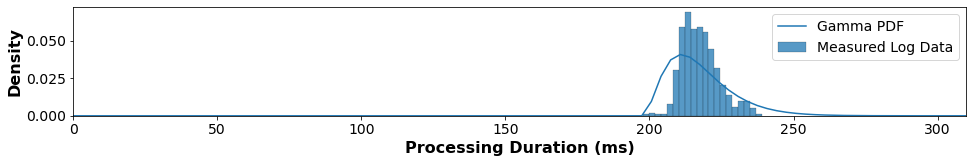

P-value(gamma) = KstestResult(statistic=0.2015330125497134, pvalue=8.087991198172312e-40)
Percentage of data cleaned: 5.23156089193825, #samples: 1105
#nodes = 3
alpha=3
loc=199.15346724767394
scale=7.040128615052123


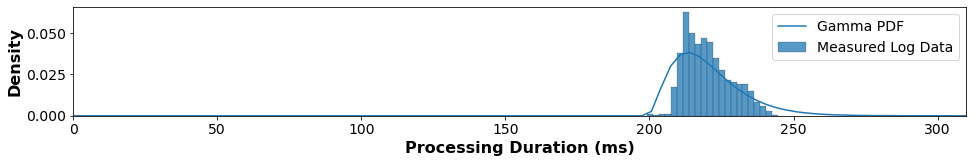

P-value(gamma) = KstestResult(statistic=0.14355678113458886, pvalue=3.432404718339042e-20)
Percentage of data cleaned: 4.608695652173913, #samples: 1097
#nodes = 4
alpha=3
loc=172.12006429106998
scale=14.605136337931107


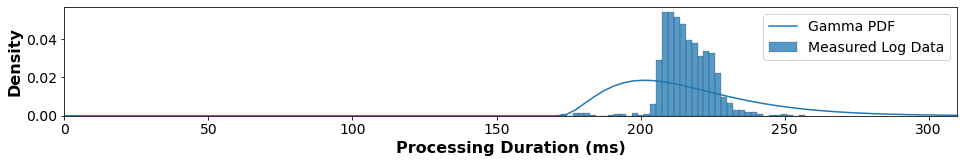

P-value(gamma) = KstestResult(statistic=0.36459720837064447, pvalue=1.6047003645598984e-109)
Percentage of data cleaned: 6.345957011258956, #samples: 915
#nodes = 5
alpha=3
loc=178.3231925512874
scale=13.459101080375842


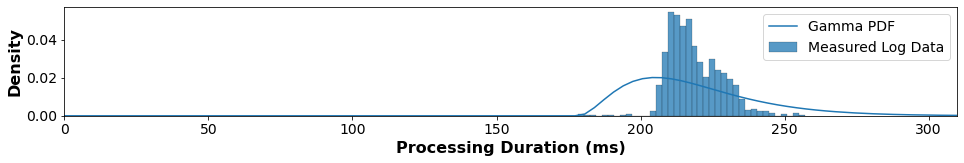

P-value(gamma) = KstestResult(statistic=0.3216614361998064, pvalue=3.5042945696832635e-84)
Percentage of data cleaned: 5.803108808290156, #samples: 909
#nodes = 6
alpha=3
loc=159.961377126355
scale=18.039174451835382


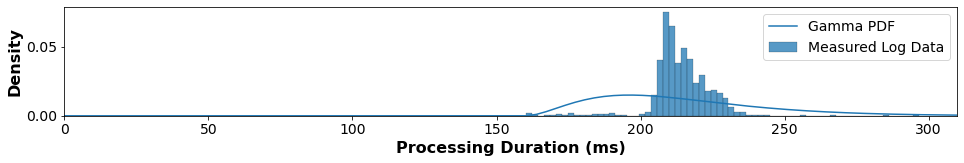

P-value(gamma) = KstestResult(statistic=0.39969261228462544, pvalue=2.175287300758474e-97)
Percentage of data cleaned: 6.013986013986014, #samples: 672
#nodes = 7
alpha=3
loc=112.63766180895229
scale=34.70587183121099


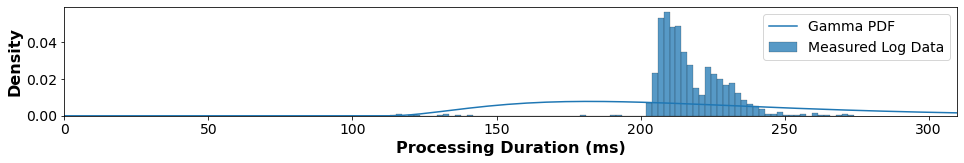

P-value(gamma) = KstestResult(statistic=0.46522786367033836, pvalue=1.9659900861363179e-171)
Percentage of data cleaned: 4.751381215469613, #samples: 862
#nodes = 8
alpha=3
loc=150.8167506052977
scale=22.634790570052637


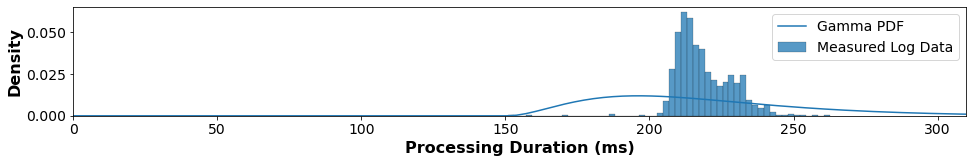

P-value(gamma) = KstestResult(statistic=0.4196642952478018, pvalue=1.013129645443798e-127)
Percentage of data cleaned: 5.791962174940898, #samples: 797
#nodes = 9
alpha=3
loc=201.73091403640052
scale=6.031107339672825


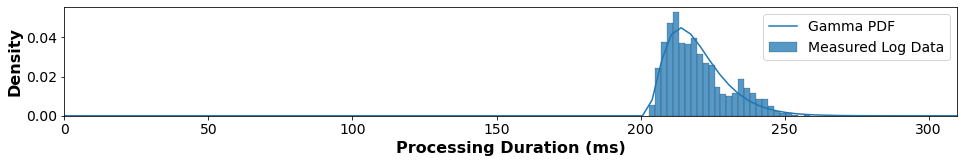

P-value(gamma) = KstestResult(statistic=0.053569347552615776, pvalue=0.019757107728726204)
Percentage of data cleaned: 5.450236966824645, #samples: 798
#nodes = 10
alpha=3
loc=91.29377862070498
scale=41.31390976372056


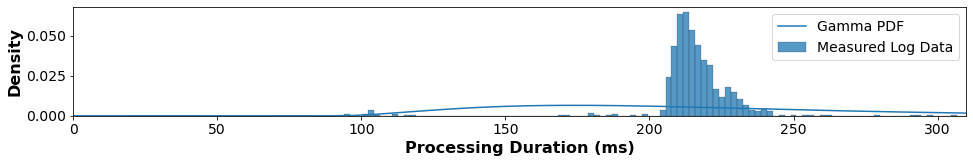

P-value(gamma) = KstestResult(statistic=0.48167268605651675, pvalue=4.47622123285998e-152)
Percentage of data cleaned: 4.697986577181208, #samples: 710
#nodes = 11
alpha=3
loc=200.79869938062305
scale=6.148893584948922


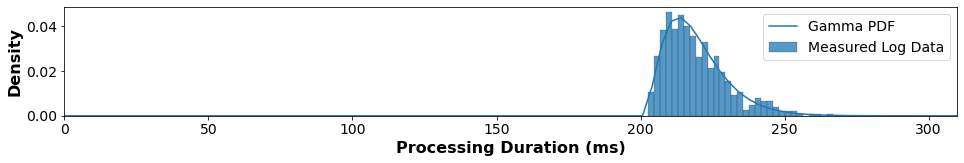

P-value(gamma) = KstestResult(statistic=0.028420779155337472, pvalue=0.5922528911287623)
Percentage of data cleaned: 6.580645161290323, #samples: 724
#nodes = 12
alpha=3
loc=174.69549507496777
scale=14.524480679131123


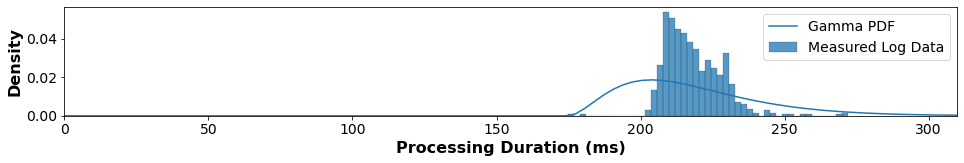

P-value(gamma) = KstestResult(statistic=0.33173664123178037, pvalue=1.1057934708567957e-67)
Percentage of data cleaned: 6.548431105047749, #samples: 685
#nodes = 13
alpha=3
loc=204.1761223872614
scale=5.742614865571474


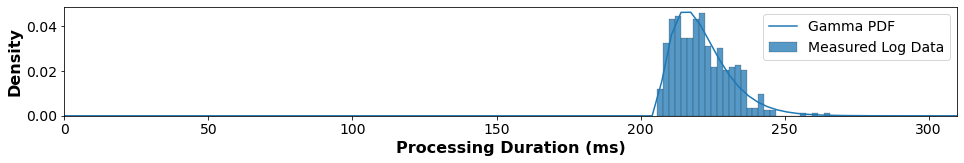

P-value(gamma) = KstestResult(statistic=0.04765706707488426, pvalue=0.30948279771931164)
Percentage of data cleaned: 7.35632183908046, #samples: 403
#nodes = 14
alpha=3
loc=204.75811650098854
scale=5.24112835737489


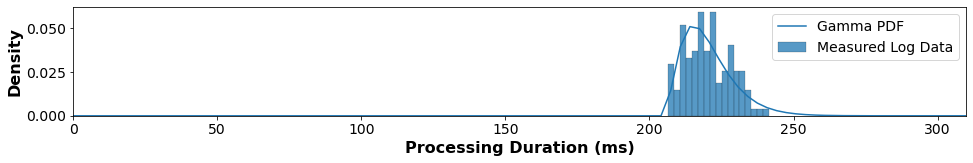

P-value(gamma) = KstestResult(statistic=0.0823917858262459, pvalue=0.31852592303622107)
Percentage of data cleaned: 5.755395683453238, #samples: 131
#nodes = 15
alpha=3
loc=204.5195984987601
scale=6.096997189687162


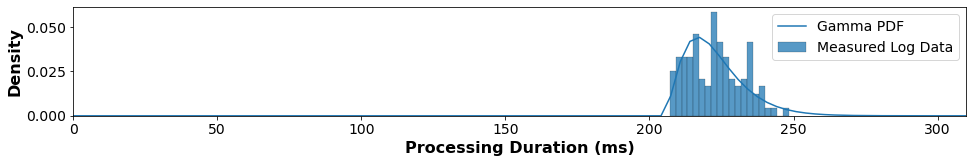

P-value(gamma) = KstestResult(statistic=0.10813978989967116, pvalue=0.12315950094552085)
Percentage of data cleaned: 5.691056910569105, #samples: 116
#nodes = 16
alpha=3
loc=172.63320592066492
scale=18.816574129461728


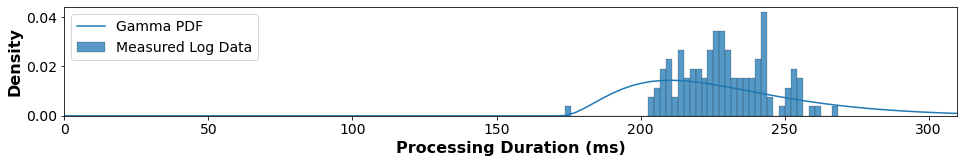

P-value(gamma) = KstestResult(statistic=0.2289872808080276, pvalue=2.4581456707705087e-06)
Percentage of data cleaned: 6.61764705882353, #samples: 127


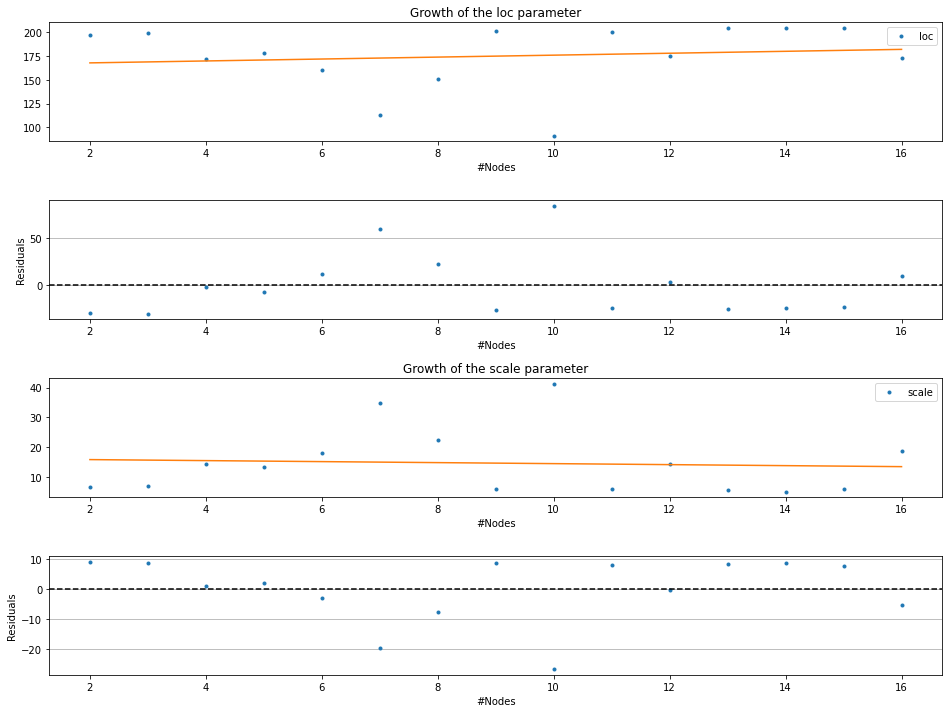

In [9]:
#/merged/jp_consensus_process_new_round.csv
#/merged/jp_consensus_process_proposal_own.csv
#/merged/jp_consensus_process_proposal_other.csv
#/merged/jp_consensus_ensure_round_and_sync_up.csv
frame_number = 0

# Calculate the x-axis limits
data = data_frames[frame_number]['duration']
#data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
xlim_start = 0#np.mean(data) - 3*np.std(data)
data = data_frames[(len(experiment_type)-1) * 4 + frame_number]['duration']
data = data[(data <= data.mean() + 2*data.std()) & (data >= data.mean() - 3*data.std())]
xlim_end = np.mean(data) + 3*np.std(data)
x_axis_range = xlim_end - xlim_start

gamma_zipped_parameters = []
a_list = []
loc_list = []
scale_list = []
for index in range(len(experiment_type)):
    print('#nodes = ' + str(index+2))
    #fig, (ax0, ax1) = plt.subplots(2,1,figsize=(16,4))
    fig, ax0 = plt.subplots(1,1,figsize=(16,2))

    data = data_frames[index*4 + frame_number]['duration']
    
    #fig2, (ax2) = plt.subplots(1,1,figsize=(16,4))
    #sns.boxplot(data=data.to_numpy(), ax=ax2)
    
    data = data[round(0.3*len(data)):]

    #Clean the data a bit
    data_start = len(data)
    data = data[data.between(data.quantile(0.02), data.quantile(.98))]
    data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    #data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    #data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    data_end = len(data)
    
    #data = data.values.reshape(-1,1)

    #model = mixture.GaussianMixture(n_components=6)
    #model.fit(data)
    #data_samples = model.sample(len(data))
    
    #GAMMA TEST
    a, loc, scale = stats.gamma.fit(data, f0=3)
    print("alpha=" + str(a))
    print("loc=" + str(loc))
    print("scale=" + str(scale))
    a_list.append(a); loc_list.append(loc); scale_list.append(scale)
    gamma_zipped = zip([a], [loc], [scale])
    gamma_zipped_parameters.append(gamma_zipped)
    
    gamma_fit = stats.gamma(a, loc, scale)
    p_gamma_fit = stats.kstest(data, gamma_fit.cdf)

    #a, beta, loc, scale = stats.beta.fit(data, f0=30)
    #gamma_zipped = zip([a], [beta], [loc], [scale])
    #gamma_zipped_parameters.append(gamma_zipped)
    #beta_fit = stats.beta(alpha, beta, loc, scale)
    #p_beta_fit = stats.kstest(data, beta_fit.cdf)

    #Fitting the gamma distribution
    X = np.linspace(0, 1000, 300)
    ax0.plot(X, gamma_fit.pdf(X), label="Gamma PDF")
    #ax0.plot(X, beta_fit.pdf(X), label="Estimated beta function")
    #END GAMMA TEST

    sns.histplot(data, ax=ax0, stat="density", label="Measured Log Data", binwidth=x_axis_range/150)
    #sns.histplot(data_samples[0], ax=ax1, stat="density", label="Real Data", binwidth=x_axis_range/150)
    ax0.set_xlim(xlim_start, xlim_end)
    #ax1.set_xlim(xlim_start, xlim_end)
    ax0.set_xlabel('Processing Duration (ms)', fontweight='bold')
    ax0.set_ylabel('Density', fontweight='bold')
    
    ax0.xaxis.label.set_size(16)
    ax0.yaxis.label.set_size(16)
    ax0.xaxis.set_tick_params(labelsize=14)
    ax0.yaxis.set_tick_params(labelsize=14)
    
    ax0.legend(fontsize=14)
    plt.show()

    #p_value = stats.ks_2samp(np.array(data).flatten(), data_samples[0].flatten())
    #print('P-value = ' + str(p_value[1]))
    print('P-value(gamma) = ' + str(p_gamma_fit))
    print("Percentage of data cleaned: " + str((data_start-data_end)/data_start*100) + ", #samples: " + str(data_end))
    #print('Means = ' + str(model.means_))
    #print('weights = ' + str(model.weights_))
    #print('variances = ' + str(model.covariances_))
    
# Plot the loc and scale parameters and perform linear fit
coefficients_loc = np.polyfit(range(2, len(loc_list)+2), loc_list, 1)
poly_loc = np.poly1d(coefficients_loc)

coefficients_scale = np.polyfit(range(2, len(scale_list)+2), scale_list, 1)
poly_scale = np.poly1d(coefficients_scale)

fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,1,figsize=(16,12), gridspec_kw={'hspace':0.5})
# Plot loc + residuals
ax0.plot(range(2, len(loc_list)+2), loc_list, '.', label="loc")
ax0.plot(range(2, len(loc_list)+2), poly_loc(range(2, len(loc_list)+2)))
ax0.set_title("Growth of the loc parameter")
ax0.set_xlabel('#Nodes')
ax0.legend()

pred_loc = poly_loc(range(2, len(loc_list)+2)) - loc_list
ax1.plot(range(2, len(loc_list)+2), pred_loc, '.')
ax1.set_xlabel('#Nodes')
ax1.set_ylabel('Residuals')
ax1.grid(axis='y')
ax1.axhline(y=0, c='black', ls='--')

# Plot scale + residuals
ax2.plot(range(2, len(scale_list)+2), scale_list, '.', label="scale")
ax2.plot(range(2, len(scale_list)+2), poly_scale(range(2, len(scale_list)+2)))
ax2.set_title("Growth of the scale parameter")
ax2.set_xlabel('#Nodes')
ax2.legend();

pred_scale = poly_scale(range(2, len(scale_list)+2)) - scale_list
ax3.plot(range(2, len(scale_list)+2), pred_scale, '.')
ax3.set_xlabel('#Nodes')
ax3.set_ylabel('Residuals')
ax3.grid(axis='y')
ax3.axhline(y=0, c='black', ls='--')

In [31]:
# Generate data for the gaussian mixture distribution
def generate_data(n_data, means, covariances, weights):
    """creates a list of data points"""
    n_clusters, n_features = means.shape
    
    data = np.zeros((n_data, n_features))
    for i in range(n_data):
        # pick a cluster id and create data from this cluster
        k = np.random.choice(n_clusters, size = 1, p = weights)[0]
        x = np.random.multivariate_normal(means[k], covariances[k])
        data[i] = x
   
    return data

In [115]:
# Calculate the parameters
weights = model.means_.flatten()
means = model.means_.flatten()
variances = model.covariances_.flatten()
zipped = zip(weights, means, variances)
print(list(zipped))

[(828.9474207536912, 828.9474207536912, 687.6968937923702), (738.2225297998947, 738.2225297998947, 1223.7490306989569)]


(0.0, 1000.0)

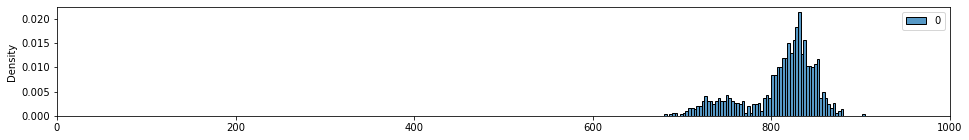

In [112]:
fig, (ax0) = plt.subplots(1,1,figsize=(16,2))

X = generate_data(1000, np.array([[742],[828]]), np.array([[[530]], [[415]]]), [.22,.78])

#model2 = mixture.GaussianMixture(n_components=2, weights_init=[.31,.69], means_init=[[389],[403]], precisions_init=[[[19]], [[17]]])
#data_samples = model2.sample(400)
sns.histplot(X, ax=ax0, stat="density", label="Real Data", binwidth=3)
ax0.set_xlim(0, 1000)

Gamma p score: KstestResult(statistic=0.3799212647523855, pvalue=1.5958773552583356e-38)
Beta p score: KstestResult(statistic=0.5016275700942059, pvalue=9.857065962144755e-69)
Percentage of data cleaned: 0.0
Gamma p score: KstestResult(statistic=0.39778766588729053, pvalue=2.7552032349691496e-97)
Beta p score: KstestResult(statistic=0.39965167503740584, pvalue=3.114608785998341e-98)
Percentage of data cleaned: 0.0
Gamma p score: KstestResult(statistic=0.41167485546279603, pvalue=5.544564689381867e-133)
Beta p score: KstestResult(statistic=0.41227309419181746, pvalue=2.1950765479098087e-133)
Percentage of data cleaned: 0.0
Gamma p score: KstestResult(statistic=0.41338875788830254, pvalue=1.7161279899477708e-172)
Beta p score: KstestResult(statistic=0.41341240296845716, pvalue=1.6367998827188505e-172)
Percentage of data cleaned: 0.0
Gamma p score: KstestResult(statistic=0.9786343595792448, pvalue=0.0)
Beta p score: KstestResult(statistic=0.38743435813471483, pvalue=4.1147595600794044e-17

IndexError: list index out of range

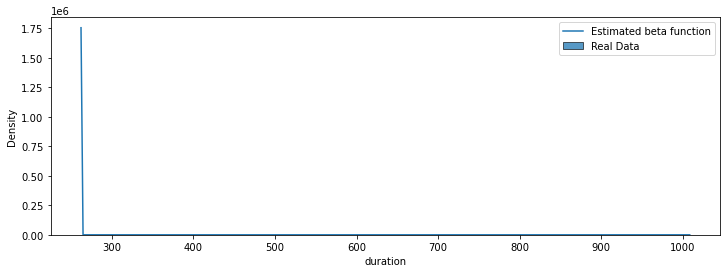

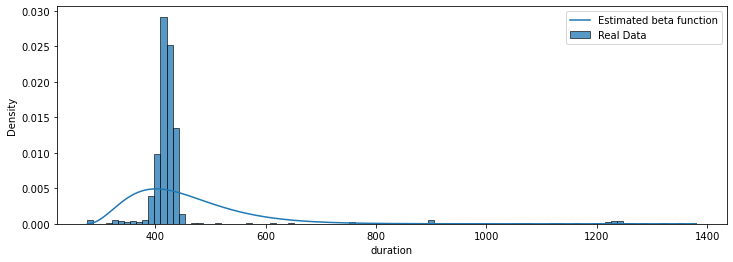

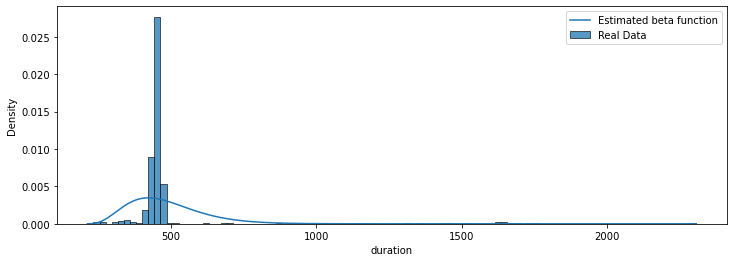

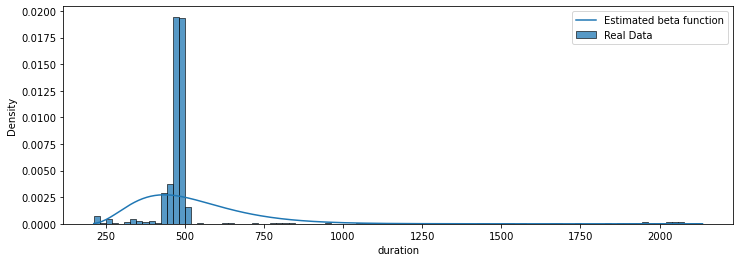

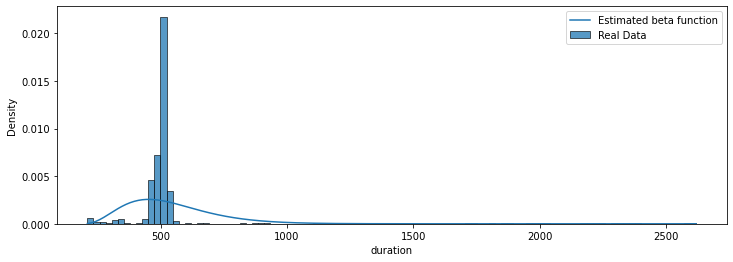

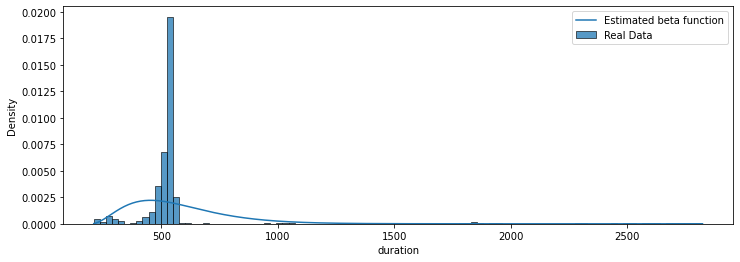

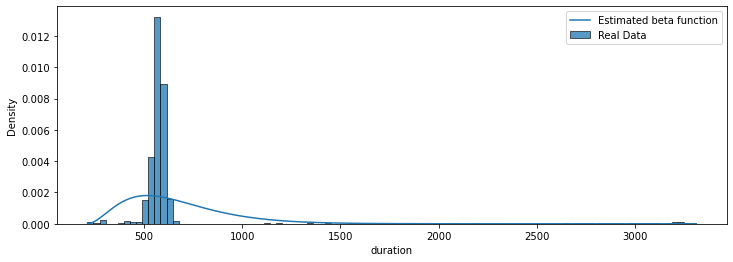

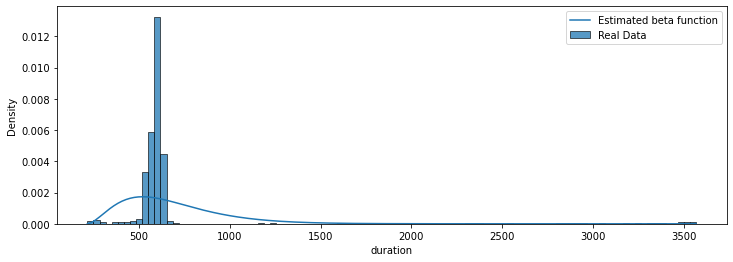

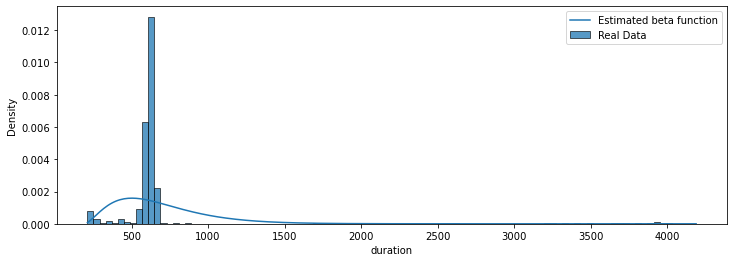

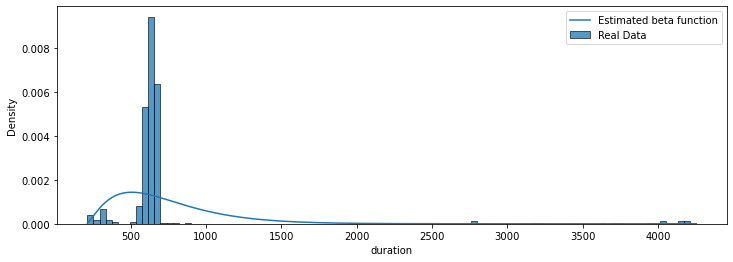

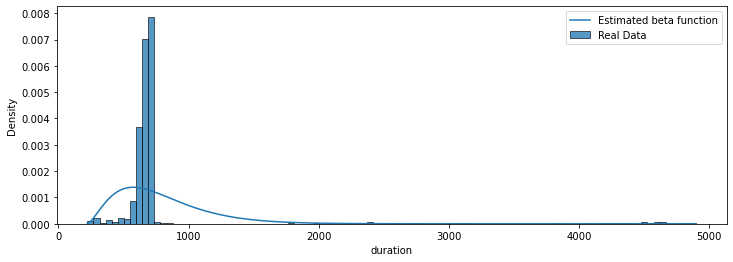

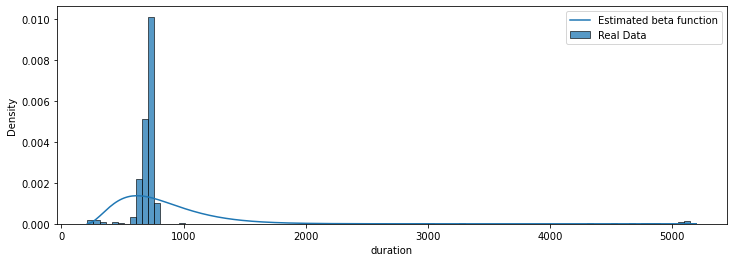

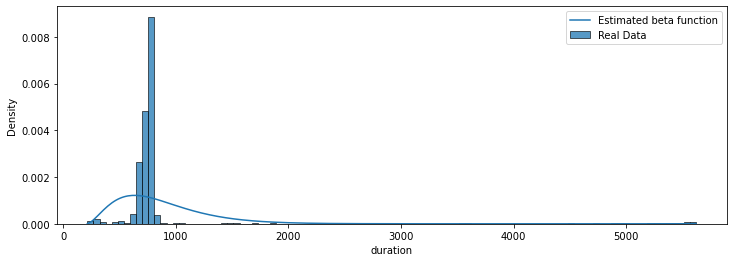

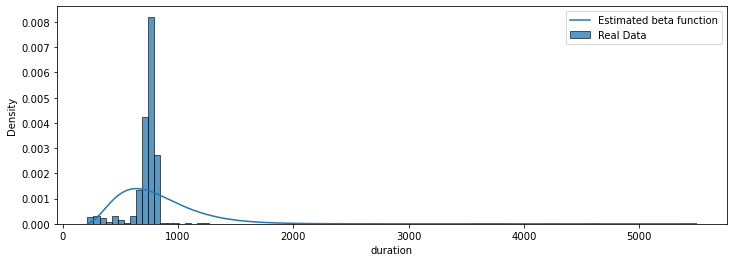

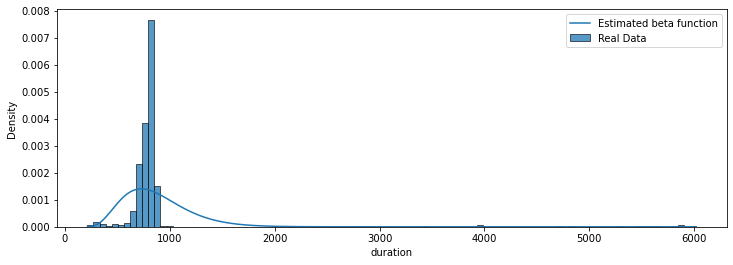

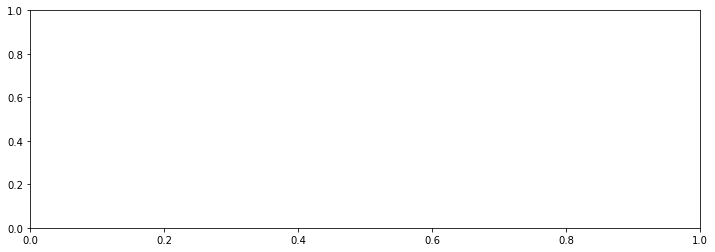

In [81]:
#0 = "/merged/jp_consensus_process_proposal.csv"
#1 = "/merged/jp_consensus_process_new_round.csv"
#2 = "/merged/jp_consensus_ensure_round_and_sync_up.csv"
#3 = "/merged/jp_consensus_process_proposal_without_sync.csv"


#Should work for 2,3 and 4
#Works for 2 and 4
frame_nr = 2
def plot_graphs(x):
    fig, ax = plt.subplots(figsize=(12,4))

    #data = data_frames[frame_nr + (x*len(tmp_frames))]['duration']
    data = data_frames[x*4 + frame_number]['duration']
    
    #data = data[round(0.2*len(data)):]

    #Clean the data a bit
    #data = data[data.between(data.quantile(.02), data.quantile(.99))]
    #data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]

    sns.histplot(data, ax=ax, stat="density", label="Real Data", bins=100)

    a, loc, scale = stats.gamma.fit(data)
    gamma_fit = stats.gamma(a, loc, scale)
    p_gamma_fit = stats.kstest(data, gamma_fit.cdf)

    alpha, beta, loc, scale = stats.beta.fit(data)
    beta_fit = stats.beta(alpha, beta, loc, scale)
    p_beta_fit = stats.kstest(data, beta_fit.cdf)

    #Fitting the gamma distribution
    X = np.linspace(min(data), max(data), 300)
    #ax.plot(X, gamma_fit.pdf(X), label="Estimated gamma function")
    ax.plot(X, beta_fit.pdf(X), label="Estimated beta function")
    ax.legend();

    print("Gamma p score: " + str(p_gamma_fit))
    print("Beta p score: " + str(p_beta_fit))
    print("Percentage of data cleaned: " + str((len(data_frames[frame_nr + (x*len(tmp_frames))]['duration']) - len(data)) / len(data_frames[frame_nr + (x*len(tmp_frames))]['duration']) * 100))
    
for x in range(0, 16):
    plot_graphs(x)